In [14]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import random

In [15]:
IMAGE_SIZE =256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [16]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [17]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [18]:
len(dataset)

141

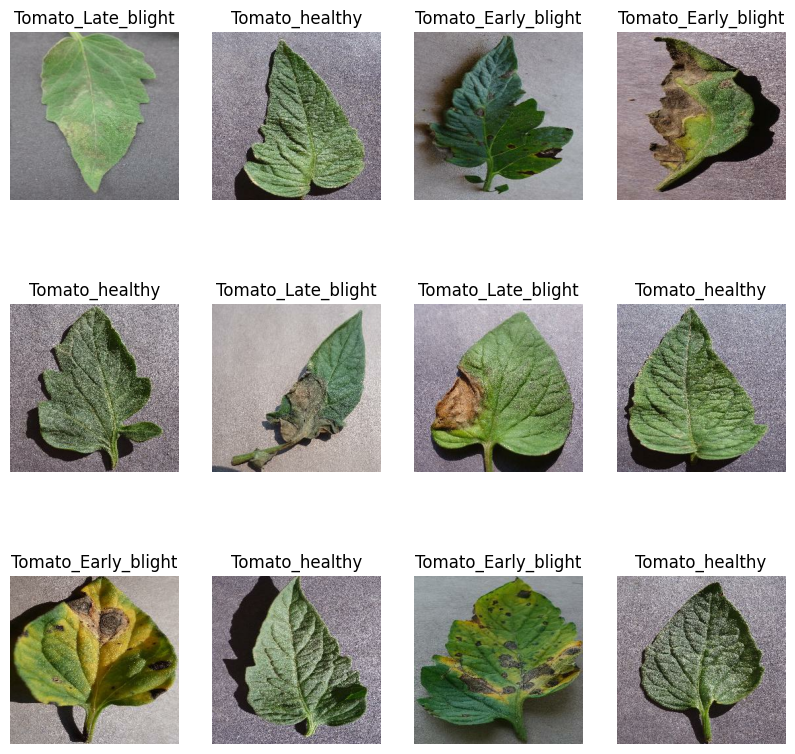

In [19]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
   

   

In [20]:
len(dataset)

141

In [21]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (829920516.py, line 1)

In [22]:
train_size = 0.8
len(dataset)*train_size

112.80000000000001

In [23]:
train_ds = dataset.take(112)
len(train_ds)

112

In [24]:
test_ds = dataset.skip(112)
len(test_ds)

29

In [25]:
val_size = 0.1
len(dataset)*val_size

14.100000000000001

In [26]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [27]:
test_ds = test_ds.skip(14)
len(test_ds)

15

In [28]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int (train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [29]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
len(train_ds)

112

In [31]:
len(val_ds)

14

In [32]:
len(test_ds)

15

In [33]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [34]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [35]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5
112/112 [==============================] - 489s 4s/step - loss: 0.9493 - accuracy: 0.5034 - val_loss: 0.7556 - val_accuracy: 0.6685
Epoch 2/5
112/112 [==============================] - 527s 5s/step - loss: 0.5912 - accuracy: 0.7228 - val_loss: 0.4414 - val_accuracy: 0.8094
Epoch 3/5
112/112 [==============================] - 487s 4s/step - loss: 0.4587 - accuracy: 0.7996 - val_loss: 0.5767 - val_accuracy: 0.7548
Epoch 4/5
112/112 [==============================] - 485s 4s/step - loss: 0.3704 - accuracy: 0.8485 - val_loss: 0.2793 - val_accuracy: 0.8877
Epoch 5/5
112/112 [==============================] - 506s 5s/step - loss: 0.2926 - accuracy: 0.8889 - val_loss: 0.2458 - val_accuracy: 0.8984


In [40]:
scores = model.evaluate(test_ds)

112/112 [==============================] - 111s 989ms/step - loss: 0.2458 - accuracy: 0.8984


In [41]:
scores


[0.2457762360572815, 0.8983762860298157]

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 112}

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

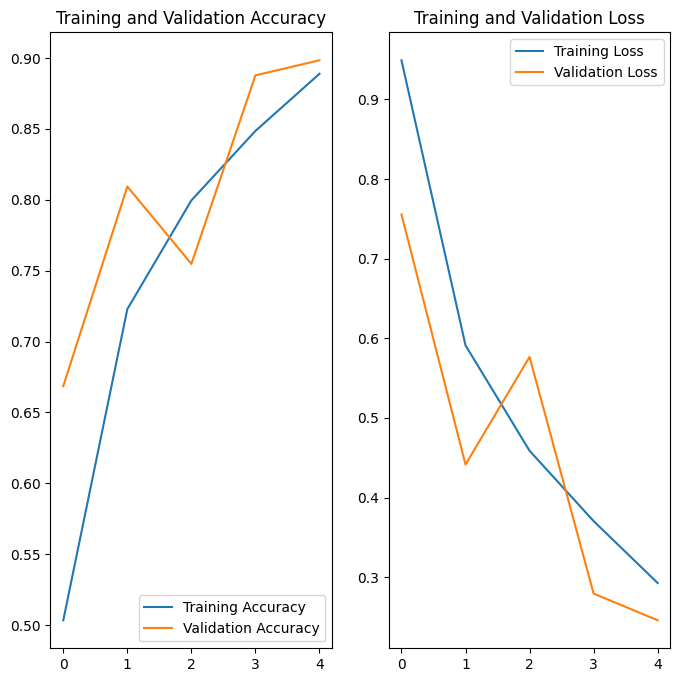

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 2s 2s/step
predicted label: Tomato_healthy


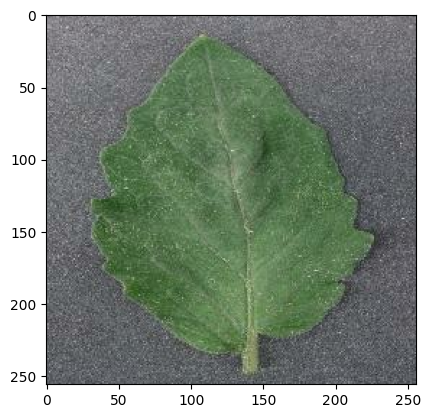

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 65ms/step


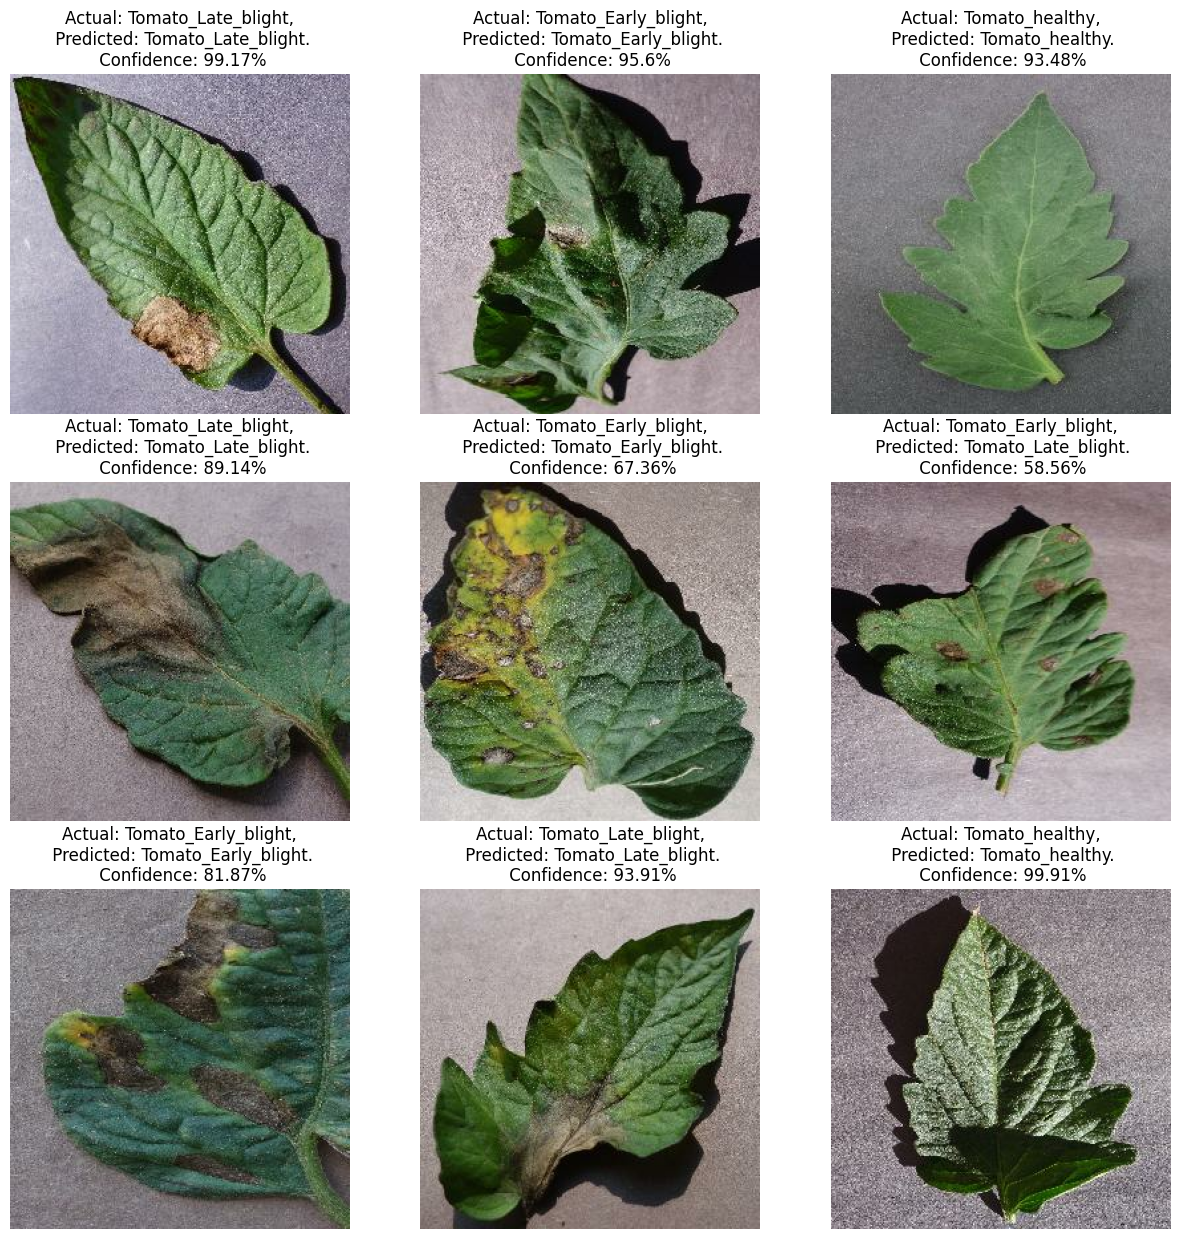

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [50]:
import os
save_dir = '/Users/nathan/Desktop/Code/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [51]:
model.save(os.path.join(save_dir, 'my_model.h5'))